In [1]:
# Libary import
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa  # Library for audio & sound
%matplotlib inline
 
from sklearn.cluster import KMeans
from scipy import interpolate
from skimage.filters import gaussian

In [2]:
np.set_printoptions(edgeitems=10)
plt.style.use('dark_background')

# Function declaration

In [3]:
# Functions for utilities
# STFT
def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

# Inverse STFT
def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)

# Amplitude to decibel
def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)

# Decibel to amplitude
def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)

# Spectogram drawing
def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Plot the statistics & mask of noise
def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

# 원본 소리

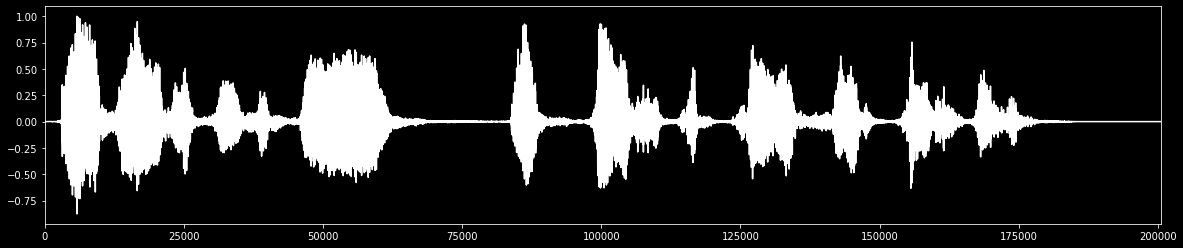

In [27]:
# Load the targe voice 
wav_loc = "fish.wav"
rate, data = wavfile.read(wav_loc) # sampling rate & data
data = data / 32768 # bit rate

# time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data, color='white')
ax.set_xlim((0, len(data)))
plt.show()

In [5]:
# Target voice play
IPython.display.Audio(data=data, rate=rate, autoplay=False)

# 노이즈 생성

In [6]:
# Function for noise generation
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

In [7]:
# noise generation
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=4000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data + noise #noisy signal

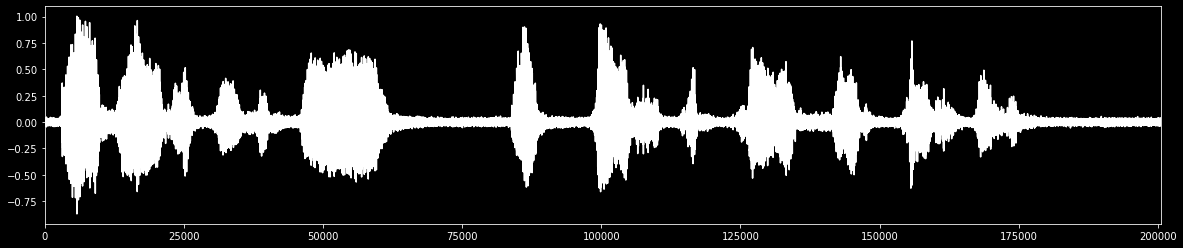

In [8]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_band_limited, color='white')
ax.set_xlim((0, len(audio_clip_band_limited)))
plt.show()

In [9]:
# Noisy sound play
IPython.display.Audio(data=audio_clip_band_limited, rate=rate, autoplay=False)

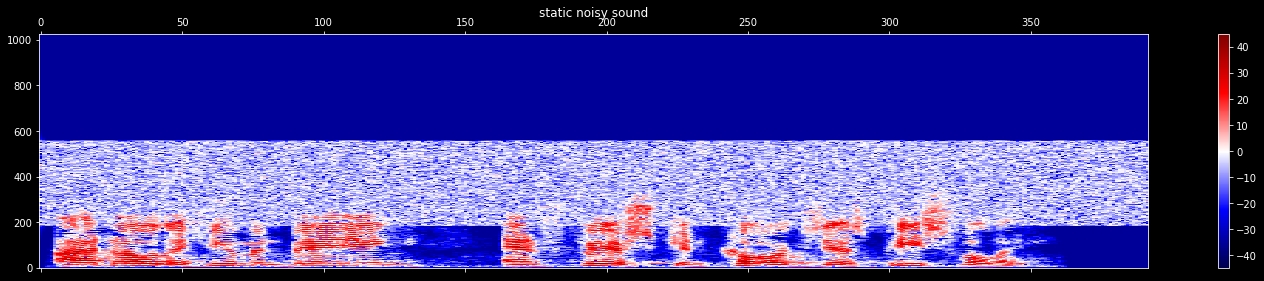

In [29]:
noise_stft = _stft(audio_clip_band_limited, 2048, 512, 2048)
noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
plot_spectrogram(noise_stft_db, title='static noisy sound')

# 시변 노이즈 생성


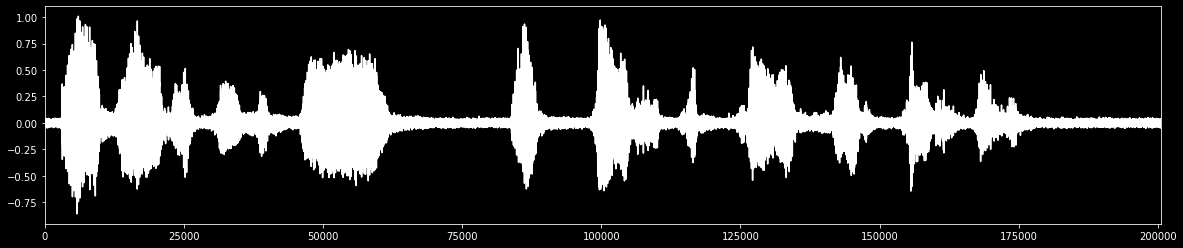

In [10]:
# Time varing noise generation
noise_len = 2
noises = []
for i in range(5):
    noises.append(band_limited_noise(min_freq=2000 + (2000 * i), max_freq=10000 + (2000 * i), samples=len(data) // 5, samplerate=rate) * 5)

dynamic_noise = np.concatenate(noises)
clip_data = data[:dynamic_noise.shape[0]]
dynamic_audio_clip_band_limited = clip_data + dynamic_noise

# Dynamic noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(dynamic_audio_clip_band_limited, color='white')
ax.set_xlim((0, len(audio_clip_band_limited)))
plt.show()

# Dynamic noisy sound play
IPython.display.Audio(data=dynamic_audio_clip_band_limited, rate=rate, autoplay=False)

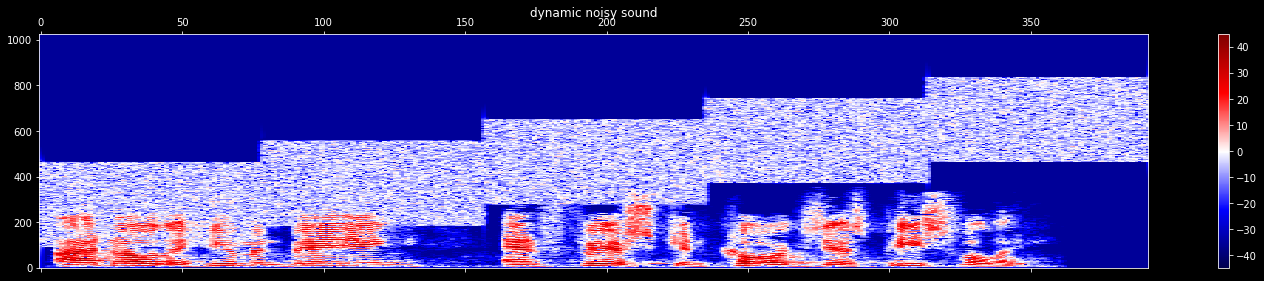

In [30]:
dynamic_noise_stft = _stft(dynamic_audio_clip_band_limited, 2048, 512, 2048)
dynamic_noise_stft_db = _amp_to_db(np.abs(dynamic_noise_stft))  # convert to dB
plot_spectrogram(dynamic_noise_stft_db, title='dynamic noisy sound')

# My idea

In [12]:
# Normalize to [-1, 1]
def normalize(x):
    max_x = np.max(x)
    min_x = np.min(x)
    return 2 / (max_x - min_x) * (x - min_x) - 1

In [13]:
def find_optim_k(x, max_k, verbose=False):
    k_range = range(1, max_k + 1)
 
    sse = np.zeros(max_k)
 
    for i in k_range:
        km = KMeans(n_clusters=i, random_state=0)
        pred = km.fit_predict(x)
 
        prediction = [0] * i
 
        for n in pred:
            prediction[n] += 1
 
        if verbose:
            print('K: {}, prediction: {}, SSE: {}'.format(i, prediction, km.inertia_))
 
        sse[i - 1] = km.inertia_
    
    sse /= sse[0]
 
    grad = -np.gradient(np.log(sse))
    log_grad = np.log10(grad)

    optimal_k = 1
    for k, data in enumerate(normalize(log_grad)):
        if data < 0:
            optimal_k = k
            break
 
    if verbose:
        print('\nOptimal K: ', optimal_k)
    
    # Plotting
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))
 
    # Plot SSE
    ax[0].plot(k_range, sse, marker='x')
    ax[0].set_title('Normalized Sum of Squared distances of Samples (SSE)')
    ax[0].set_xlabel('K')
    ax[0].grid(alpha=0.5)
    ax[0].set_xticks(k_range)

    # Plot log of SSE
    ax[1].plot(k_range, np.log(sse), marker='x')
    ax[1].set_title('Log of Normalized Sum of Squared distances of Samples (SSE)')
    ax[1].set_xlabel('K')
    ax[1].grid(alpha=0.5)
    ax[1].set_xticks(k_range)

    # Plot gradient of SSE
    ax[2].plot(k_range, normalize(log_grad), marker='x')
    ax[2].set_title('Normalized Log of Negative Gradient of Log(SSE)')
    ax[2].set_xlabel('K')
    ax[2].grid(alpha=0.5)
    ax[2].set_xticks(k_range)
 
    return optimal_k

In [14]:
def my_idea(
    audio_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    verbose=False,
    visual=False,
):
 
    print('My idea\n')
 
    # STFT over signal
    audio_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    audio_stft_db = _amp_to_db(np.abs(audio_stft))  # convert to dB
 
    signal_shape = audio_stft_db.shape
 
    if verbose:
        print('signal shape: ', audio_stft_db.shape)   
 
    # Flatten noise 
    flatten_audio_stft_db = audio_stft_db.flatten()
 
    if verbose:
        print('flattened signal shape: ', flatten_audio_stft_db.shape)
        print('')
 
    zeros = [0] * flatten_audio_stft_db.shape[0]
 
    # map datas onto y-axis
    zip_flatten_audio_stft_db = list(zip(zeros, flatten_audio_stft_db))
 
    # get optimal number of cluster
    op_k = find_optim_k(zip_flatten_audio_stft_db, max_k=10, verbose=True)
 
    # cluster signal
    km = KMeans(n_clusters=op_k, random_state=0)
    pred = km.fit_predict(zip_flatten_audio_stft_db)  
 
    # seperate clustered signal
    clustered = [[] for _ in range(op_k)]
    for i, data in enumerate(flatten_audio_stft_db):
        clustered[pred[i]].append(data)
 
    # calulate each cluster's max
    clustered_max = []
    for i in range(op_k):
        clustered_max.append(np.max(clustered[i]))
 
    # calculate index of max, min cluster
    arg_max = np.argmax(clustered_max)
    arg_min = np.argmin(clustered_max)
    
    if verbose:
        print('cluster max: ', clustered_max)
        print('arg max: ', arg_max)
        print()
        for i in range(op_k):
            print('cluster[{}]: {}'.format(i, len(clustered[i])))
 
    # mask if not argmax cluster
    mask = np.array([i != arg_max for i in pred])
 
    mask = mask.reshape(signal_shape)
    smoothed_mask = gaussian(mask)
 
    signal_min = np.min(audio_stft_db)
 
    denoised_real_audio_stft_db = audio_stft_db * (1 - smoothed_mask) + signal_min * smoothed_mask
    denoised_imag_audio_stft_db = np.imag(audio_stft_db) * (1 - smoothed_mask)
 
    denoised_audio_stft_db = (_db_to_amp(denoised_real_audio_stft_db) * np.sign(audio_stft)) + (1j * denoised_imag_audio_stft_db)
 
    if verbose:
        print('\ndenoised signal shape:', denoised_audio_stft_db.shape)
 
    # ifft signal
    recovered_signal = _istft(denoised_audio_stft_db, hop_length, win_length)
 
    if visual:
        plot_spectrogram(audio_stft_db, title="Signal")
        plot_spectrogram(mask.reshape(signal_shape), title='mask')
        plot_spectrogram(smoothed_mask.reshape(signal_shape), title='smoothed mask')
        plot_spectrogram(denoised_real_audio_stft_db.reshape(signal_shape), title="Denoised Signal")
 
    return recovered_signal

# Applied to static-noisy sound

My idea

signal shape:  (1025, 392)
flattened signal shape:  (401800,)

K: 1, prediction: [401800], SSE: 111302715.86694317
K: 2, prediction: [210512, 191288], SSE: 15767285.695938095
K: 3, prediction: [207332, 29077, 165391], SSE: 7373679.315481282
K: 4, prediction: [115899, 202118, 22512, 61271], SSE: 3706448.0142485797
K: 5, prediction: [77729, 199217, 19952, 76780, 28122], SSE: 2422381.351629469
K: 6, prediction: [25247, 82118, 198890, 19642, 65949, 9954], SSE: 1712615.6234814087
K: 7, prediction: [18287, 52820, 197918, 16452, 41097, 8029, 67197], SSE: 1221090.5408195646
K: 8, prediction: [197042, 59249, 7162, 26953, 15053, 13726, 48742, 33873], SSE: 937014.8040402717
K: 9, prediction: [196828, 54426, 4968, 41544, 14095, 23231, 12464, 10863, 43381], SSE: 747714.2921974013
K: 10, prediction: [16688, 196278, 32207, 9485, 4128, 43065, 9822, 29045, 12518, 48564], SSE: 596370.381968814

Optimal K:  3
cluster max:  [-20.584904, 44.78169, 2.7399187]
arg max:  1

cluster[0]: 207332
cluster

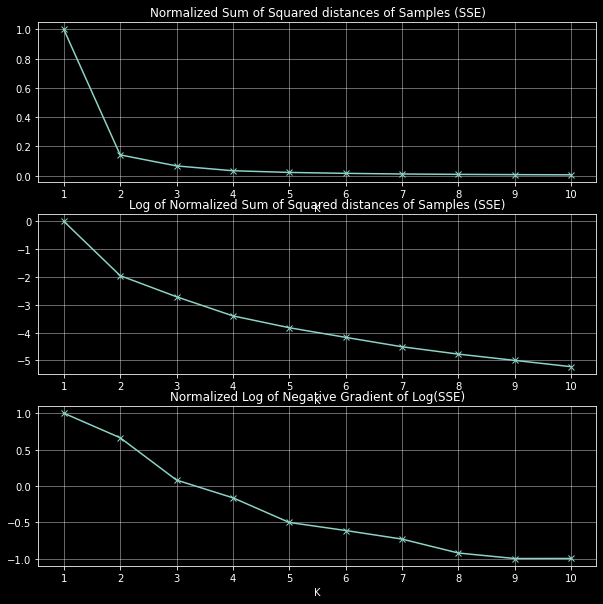

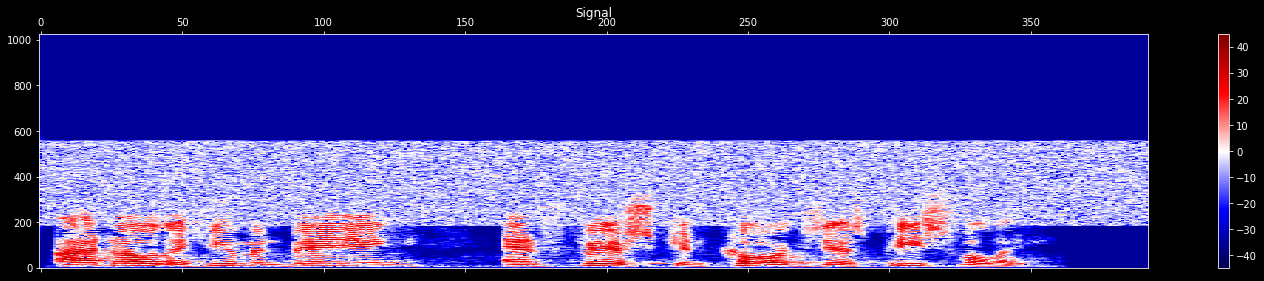

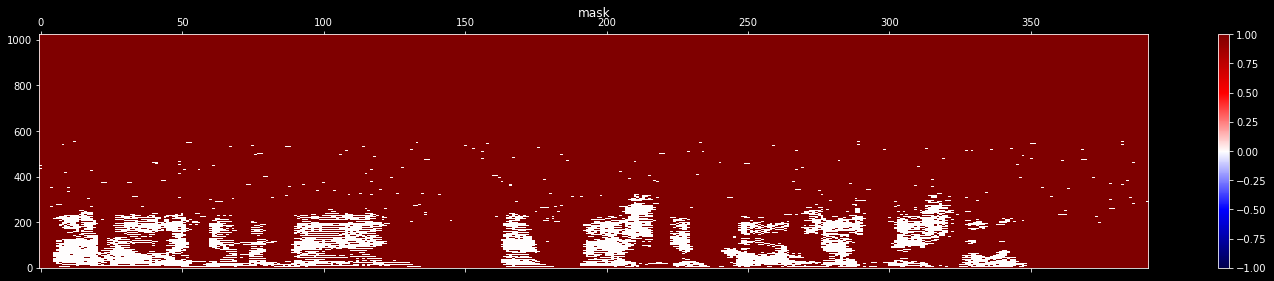

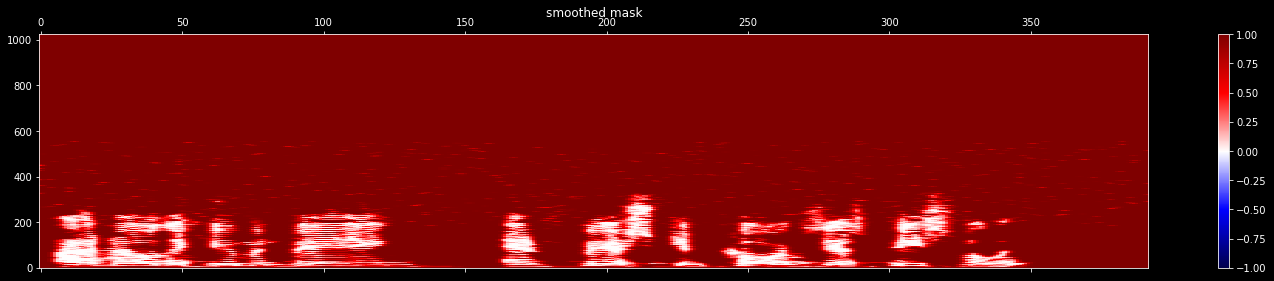

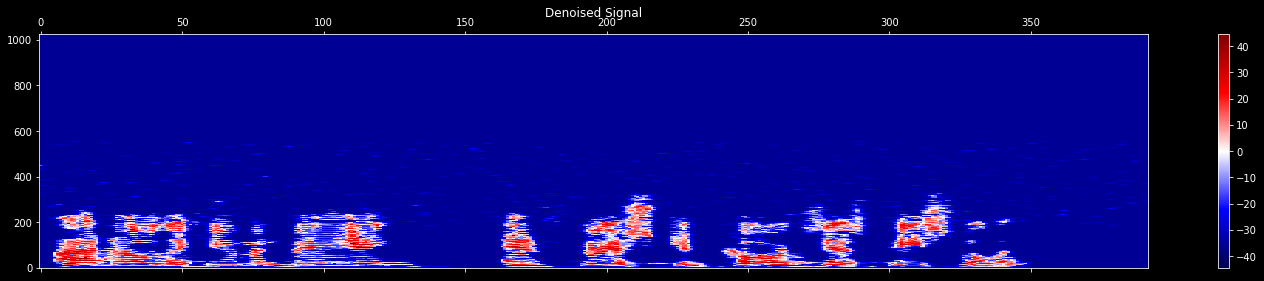

In [15]:
output = my_idea(audio_clip=audio_clip_band_limited, verbose=True, visual=True)

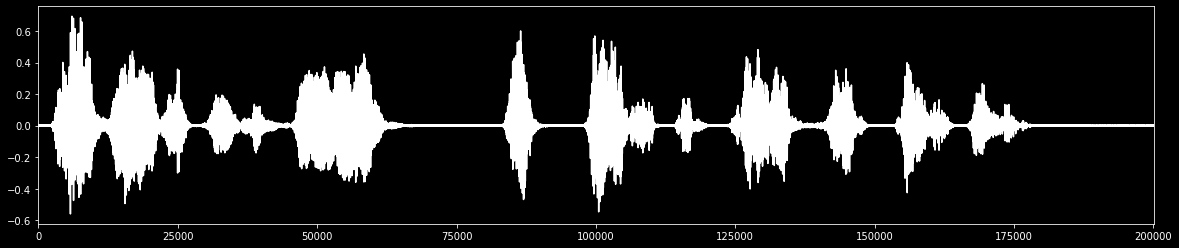

In [16]:
# Recovered sound time-domain plot
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(output, color='white')
ax.set_xlim((0, len(output)))
plt.show()

# Play recovered sound
IPython.display.Audio(data=output, rate=44100)

# Applied to dynamic_noisy sound

My idea

signal shape:  (1025, 392)
flattened signal shape:  (401800,)

K: 1, prediction: [401800], SSE: 112536481.06572972
K: 2, prediction: [203596, 198204], SSE: 16244762.832137717
K: 3, prediction: [171791, 200171, 29838], SSE: 8251628.009866955
K: 4, prediction: [126813, 192750, 22135, 60102], SSE: 4062259.2504616664
K: 5, prediction: [29889, 87304, 188721, 19571, 76315], SSE: 2599062.940200839
K: 6, prediction: [187035, 81158, 16202, 21762, 48868, 46775], SSE: 1884134.9633012589
K: 7, prediction: [186599, 62631, 7985, 39351, 19799, 16310, 69125], SSE: 1330222.102052314
K: 8, prediction: [25874, 185325, 47334, 14956, 63279, 7091, 15344, 42597], SSE: 1010589.2600279707
K: 9, prediction: [51318, 184667, 25763, 18900, 13430, 6016, 33252, 12841, 55613], SSE: 810214.0657086126
K: 10, prediction: [17465, 184608, 44993, 12160, 53205, 8485, 12402, 35366, 3465, 29651], SSE: 652455.0335719873

Optimal K:  3
cluster max:  [2.9244783, -20.197437, 44.78169]
arg max:  2

cluster[0]: 171791
clus

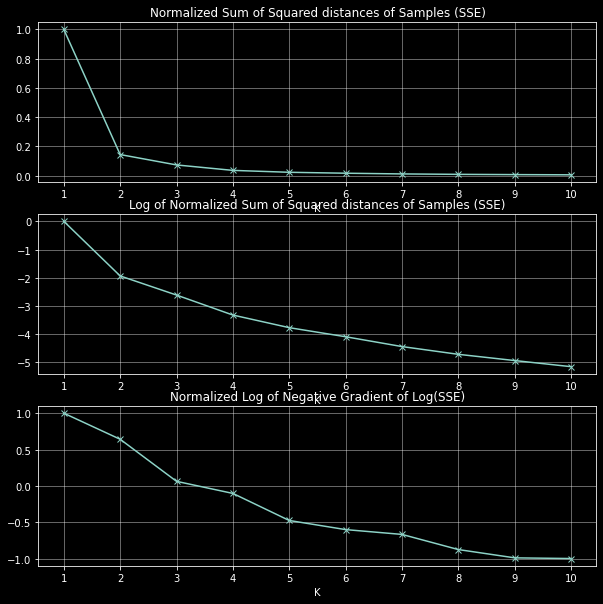

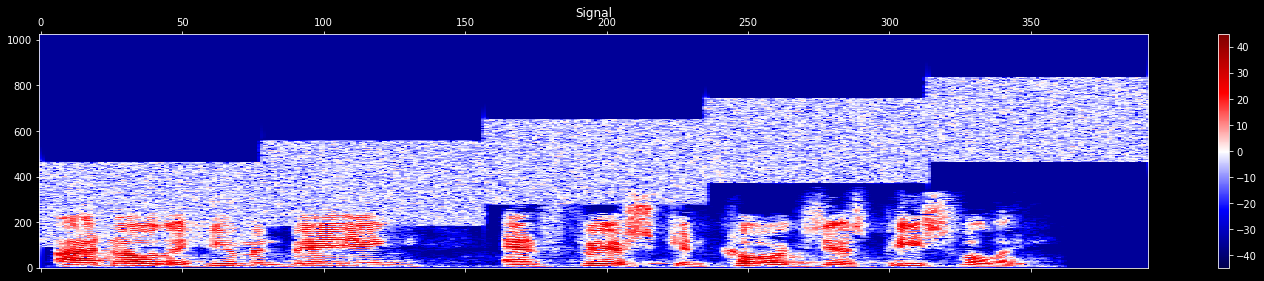

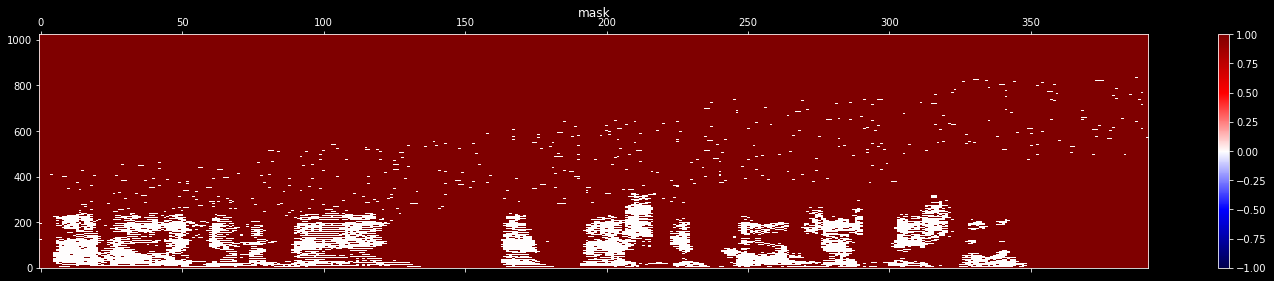

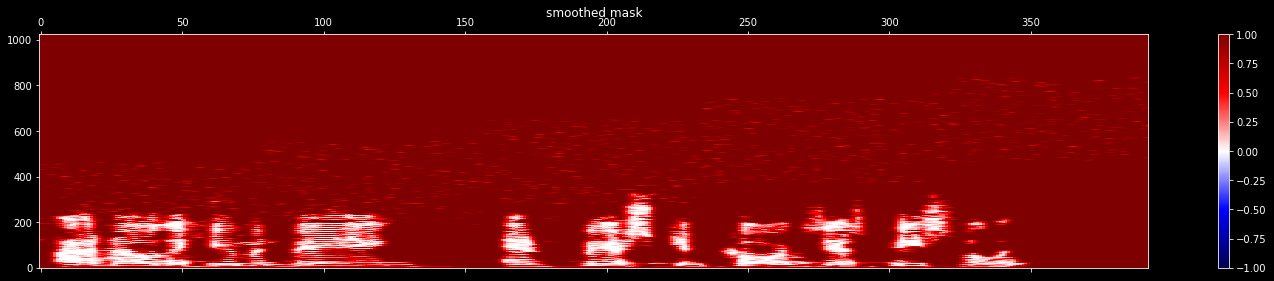

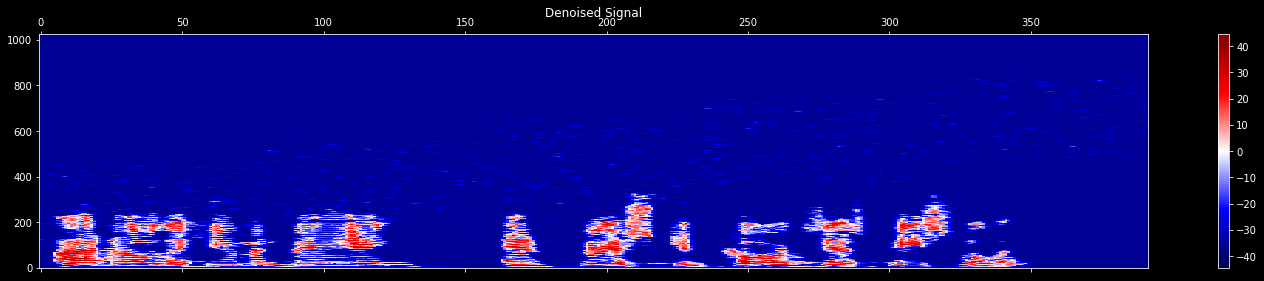

In [17]:
dynamic_output = my_idea(audio_clip=dynamic_audio_clip_band_limited, verbose=True, visual=True)

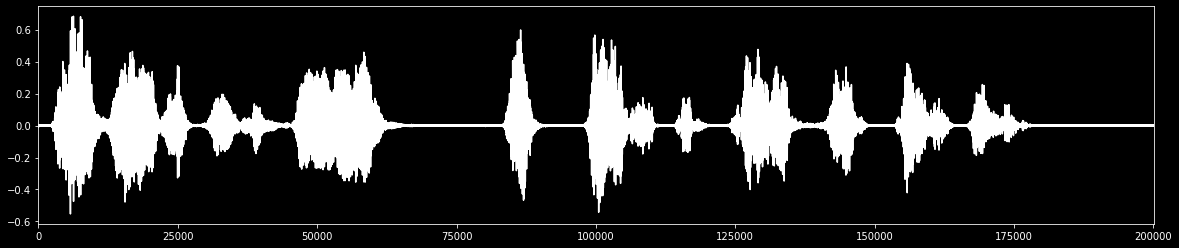

In [18]:
# Recovered sound time-domain plot
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(dynamic_output, color='white')
ax.set_xlim((0, len(dynamic_output)))
plt.show()

# Play recovered sound
IPython.display.Audio(data=dynamic_output, rate=44100)

# Summary

## Original sound

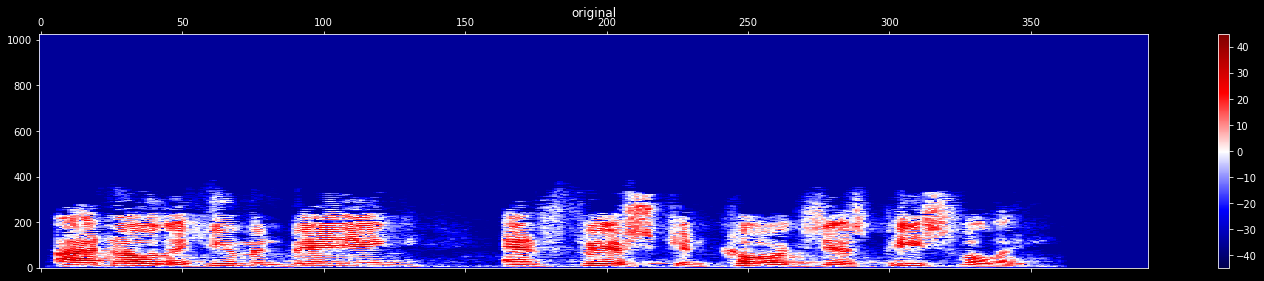

In [19]:
data_stft = _stft(data, 2048, 512, 2048)
data_stft_db = _amp_to_db(np.abs(data_stft))  # convert to dB
plot_spectrogram(data_stft_db, title='original')
IPython.display.Audio(data=data, rate=44100)

## Noisy sound

### Static noise

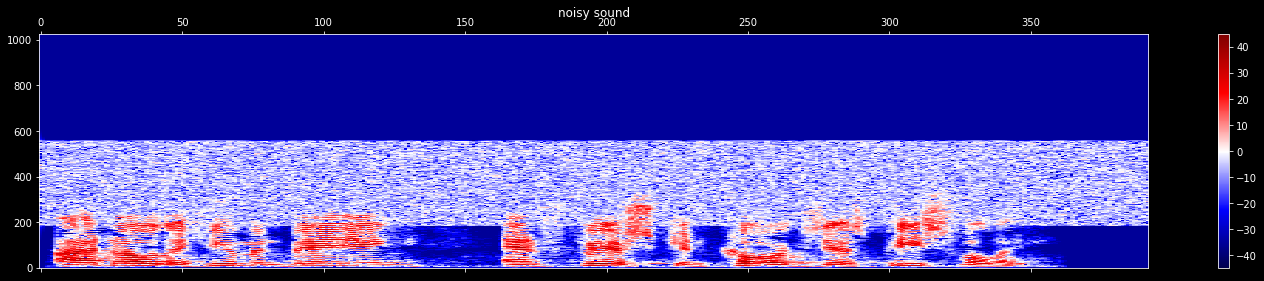

In [20]:
noisy_stft = _stft(audio_clip_band_limited, 2048, 512, 2048)
noisy_stft_db = _amp_to_db(np.abs(noisy_stft))  # convert to dB
plot_spectrogram(noisy_stft_db, title='noisy sound')
IPython.display.Audio(data=audio_clip_band_limited, rate=44100)

### Dynamic noise

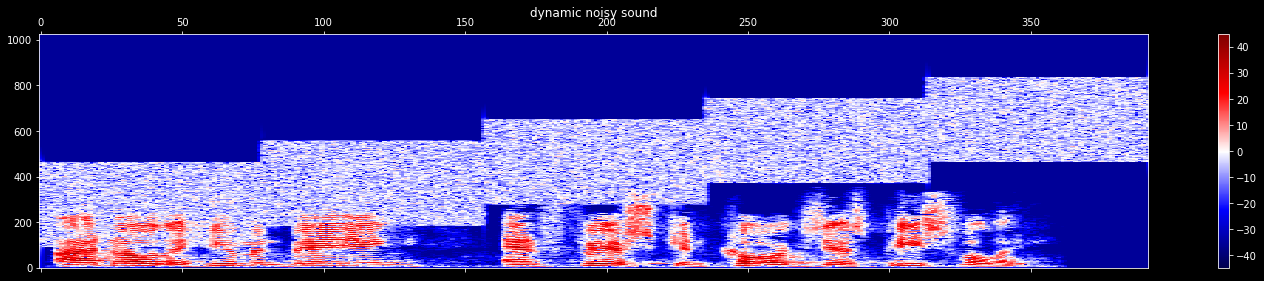

In [21]:
dynamic_noisy_stft = _stft(dynamic_audio_clip_band_limited, 2048, 512, 2048)
dynamic_noisy_stft_db = _amp_to_db(np.abs(dynamic_noisy_stft))  # convert to dB
plot_spectrogram(dynamic_noisy_stft_db, title='dynamic noisy sound')
IPython.display.Audio(data=dynamic_audio_clip_band_limited, rate=44100)

## Given noise reduction algorithm result

### Denoise w/ mean, std w/ noise info

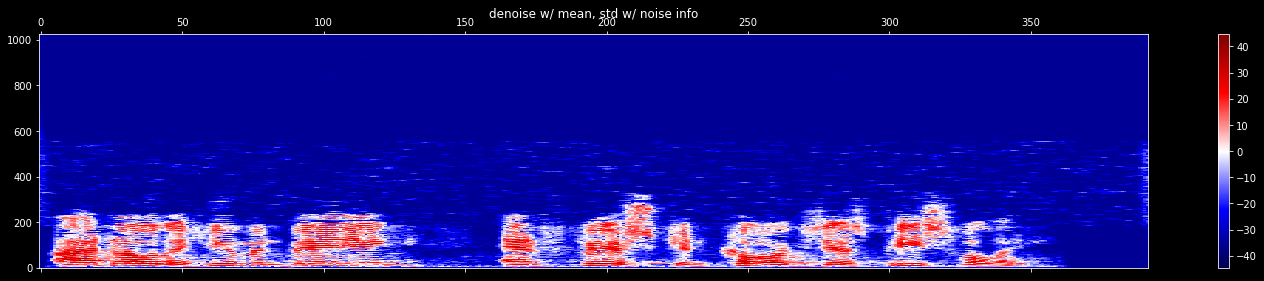

In [22]:
wav_loc = "denoised_with_noise_info.wav"
rate, given1_data = wavfile.read(wav_loc) # sampling rate & data
given1_data = given1_data / 32768 # bit rate

given1_data_stft = _stft(given1_data, 2048, 512, 2048)
given1_data_stft_db = _amp_to_db(np.abs(given1_data_stft))  # convert to dB
plot_spectrogram(given1_data_stft_db, title='denoise w/ mean, std w/ noise info')

IPython.display.Audio(data=given1_data, rate=rate, autoplay=False)

### Denoised w/ mean, std w/o noise info

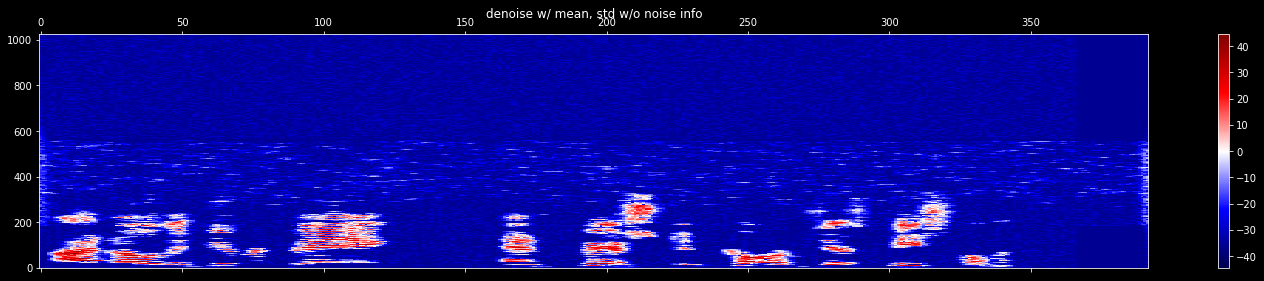

In [23]:
wav_loc = "denoised_without_noise_info.wav"
rate, given2_data = wavfile.read(wav_loc) # sampling rate & data
given2_data = given2_data / 32768 # bit rate

given2_data_stft = _stft(given2_data, 2048, 512, 2048)
given2_data_stft_db = _amp_to_db(np.abs(given2_data_stft))  # convert to dB
plot_spectrogram(given2_data_stft_db, title='denoise w/ mean, std w/o noise info')

IPython.display.Audio(data=given2_data, rate=rate, autoplay=False)

### Denoised w/ median w/o noise info

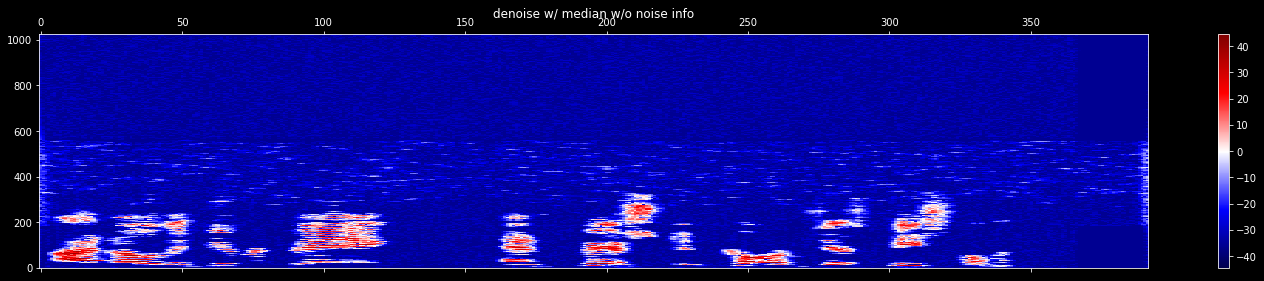

In [24]:
wav_loc = "denoised_without_noise_info(median).wav"
rate, given3_data = wavfile.read(wav_loc) # sampling rate & data
given3_data = given3_data / 32768 # bit rate

given3_data_stft = _stft(given3_data, 2048, 512, 2048)
given3_data_stft_db = _amp_to_db(np.abs(given3_data_stft))  # convert to dB
plot_spectrogram(given3_data_stft_db, title='denoise w/ median w/o noise info')

IPython.display.Audio(data=given3_data, rate=rate, autoplay=False)

## Proposing algorithm

### Static noise w/o noise info

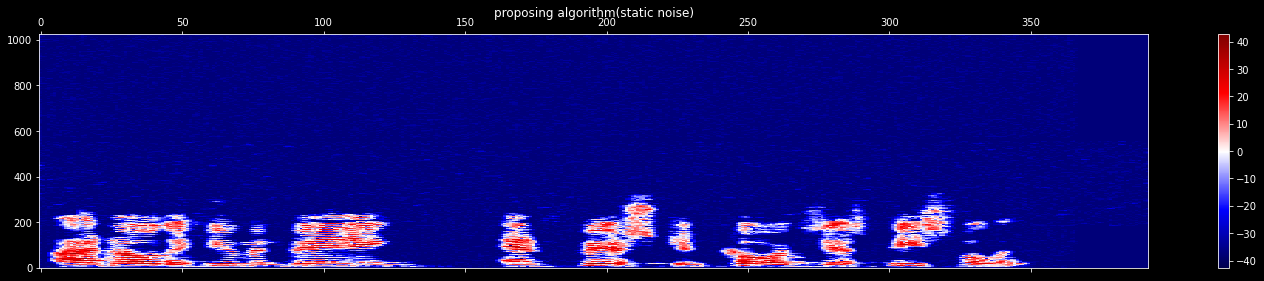

In [25]:
output_stft = _stft(output, 2048, 512, 2048)
output_stft_db = _amp_to_db(np.abs(output_stft))  # convert to dB
plot_spectrogram(output_stft_db, title='proposing algorithm(static noise)')

IPython.display.Audio(data=output, rate=44100)

### Dynamic noise w/o noise info

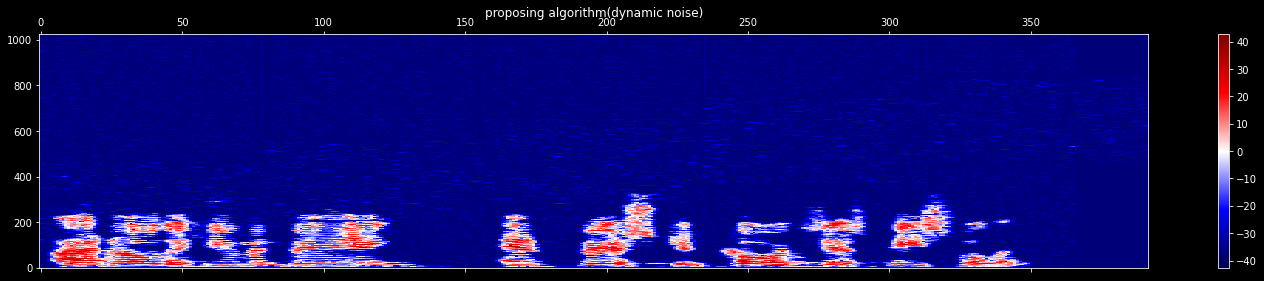

In [26]:
dynamic_output_stft = _stft(dynamic_output, 2048, 512, 2048)
dynamic_output_stft_db = _amp_to_db(np.abs(dynamic_output_stft))  # convert to dB
plot_spectrogram(dynamic_output_stft_db, title='proposing algorithm(dynamic noise)')

IPython.display.Audio(data=dynamic_output, rate=44100)